<a href="https://colab.research.google.com/github/orimosenzon/work/blob/master/colabs/FunctionFitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports 

In [0]:
import numpy as np 

import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets

import IPython

## FunctionFitter 

In [0]:
def f2(a, b, x):
    return a * x**2 + b * x  + 5


def f4(a, b, x):
    return a * x**4 + b * x ** 3 - 40 * x**2 


In [0]:
class FunctionFitter:
  def __init__(self, a=-5, b=5, a_s=2, b_s=3, f=f4, xmin=-10, xmax=10, N=40, lr=1e-4):
    self.a = a  
    self.b = b  
    self.f = f 
    self.xmin = -10
    self.xmax = 10 
    self.N = N         # number of samples
    self.lr = lr  
    self.generate_samples(self.f, a_samples=a_s, b_samples=b_s, noise=0) 
    self.delta = 1e-6 
    self.calc_mesh()
    self.init_matplotlib()
    self.x_dense = np.arange(xmin, xmax, 0.1)
    self.h_angle = 45 
    self.v_angle = 0 

    self.next_but = widgets.Button(description="Next")
    self.next_but.on_click(self.next)
    
    self.vangle_slide = widgets.IntSlider(description='Vertical angle', min=0, max=90, value=self.v_angle)
    self.vangle_slide.observe(self.on_vangle_change, names='value')
    
    self.hangle_slide = widgets.IntSlider(description='Horizontal angle', min=0, max=90, value=self.h_angle)
    self.hangle_slide.observe(self.on_hangle_change, names='value')

    self.draw()
    
  def refresh(self):
    IPython.display.clear_output()
    self.draw()
    IPython.display.display(self.fig)


  def on_vangle_change(self, change):
    self.v_angle =  change['new']
    self.refresh()


  def on_hangle_change(self, change):
    self.h_angle =  change['new']
    self.refresh()


  def next(self, but):
    print('next was pressed')
    da, db = self.grad()
    print(da,db)
    self.a -= self.lr * da
    self.b -= self.lr * db
  
    self.refresh()


  def generate_samples(self, func, a_samples, b_samples, noise):
    self.x = np.linspace(self.xmin, self.xmax, self.N)
    self.y = func(a_samples, b_samples, self.x) + np.random.rand(*self.x.shape) * noise 


  def loss(self, a, b):
    return self.loss_full(a, b, self.x, self.y)


  def loss_full(self, a, b, x, y):
    return np.sum((self.f(a, b, x) - y)**2, axis=-1) / self.N


  def grad(self): 
    current = self.loss(self.a, self.b)
    da = (self.loss(self.a + self.delta, self.b) - current) / self.delta  
    db = (self.loss(self.a, self.b  + self.delta) - current) / self.delta
    return da, db   


  def calc_mesh(self):
    self.A, self.B = np.meshgrid(np.arange(-5,5,0.5), np.arange(-50,50,5)) # shape: 20X20 
    NN = self.A.shape[0]
    X = np.tile(self.x, [NN, NN, 1]) # shape: 20X20XN , x == X[i,j]
    Y = np.tile(self.y, [NN, NN, 1])
    At = np.tile(np.expand_dims(self.A, axis=2), (1, 1, self.N))
    Bt = np.tile(np.expand_dims(self.B, axis=2), (1, 1, self.N))
    self.Z = self.loss_full(At, Bt, X, Y)

  
  def init_matplotlib(self):
    self.fig = plt.figure(figsize=(11,6))
    
    self.ax_func = self.fig.add_subplot(1,2,1)
    self.ax_loss = self.fig.add_subplot(1,2,2, projection='3d')


  def draw(self):
    output = widgets.Output()
    display(self.next_but, output)
    display(self.vangle_slide, output)
    display(self.hangle_slide, output)

    
    self.ax_func.clear()
    self.ax_func.set(title=f'Function fit a={self.a:.2f}, b={self.b:.2f}', xlabel='X', ylabel='Y')
    self.ax_func.plot(self.x_dense, self.f(self.a, self.b, self.x_dense), color='black')
    self.ax_func.plot(self.x, self.y, 'rx', color = 'darkorange')

    self.ax_loss.clear()
    self.ax_loss.view_init(self.v_angle, self.h_angle)
    self.ax_loss.set(title='Loss', xlabel='a', ylabel='b', zlabel='loss')
    self.ax_loss.plot_surface(self.A, self.B, self.Z, alpha=0.7)
    self.ax_loss.contour(self.A, self.B, self.Z, 100)
    self.ax_loss.plot([self.a], [self.b], [self.loss(self.a, self.b)], 'rx', ms=50)

  


Button(description='Next', style=ButtonStyle())

Output()

IntSlider(value=38, description='Vertical angle', max=90)

Output()

IntSlider(value=72, description='Horizontal angle', max=90)

Output()

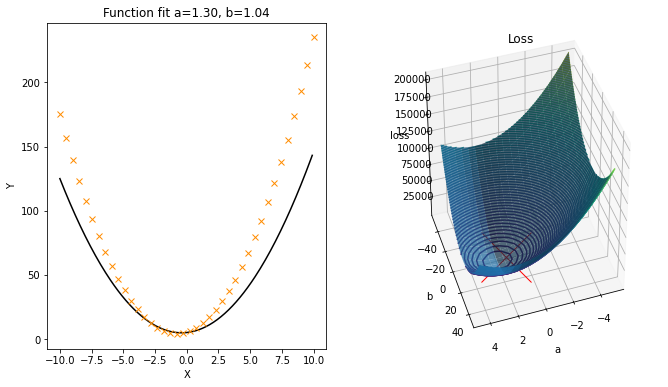

In [0]:
fitter = FunctionFitter(a=-2, b=1, f=f2, lr=1e-4)
